# Inferencia causal en modelos bayesianos: Exploración y aplicación del deconfounder en análisis de datos observacionales

Leila Sofía Asplanato - ICIFI, ICAS, ECyT, UNSAM (Bs. As.)

--------------------------------------------------
--------------------------------------------------

# Deconfounder tutorial

Vamos a aplicar el modelo de factores y de resultados, posterior a realizar el chequeo predictivo, al dataset abierto de cáncer de mamas de Scikit-Learn.

Base de datos de pacientes diagnosticados en base a estudios de cáncer de mama en Wisconsin, del año 1995 [1].
La misma cuenta con mediciones de atributos relevantes para la clasificación de tumores a partir del análisis de propiedades de núcleos celulares en las muestras histológicas de aspirado en punción de tejidos mamarios, y está disponible de manera libre en Scikit-Learn.
Dicha base de datos cuenta con 569 muestras reales con 32 atributos sin valores faltantes.
Del total de los atributos computados, los relevantes en nuestro análisis son las 10 variables de valores promedio (números reales) de cada núcleo. Como target, se tiene el diagnóstico del tumor, maligno o benigno codificado con 1 o 0 respectivamente, los cuales se distribuyen en 212 unidades malignas y 357 benignas. Las variables descartadas del análisis son los errores estándar de cada categorı́a, y los llamados ‘peores valores’ que serı́an los máximos encontrados, o el promedio de los tres mayores, en toda la muestra histológica.


[1] *Dheeru Dua and Casey Graff. UCI machine learning repository, 2017. University of California, Irvine, School of Information and Computer Sciences http://archive.ics.uci.edu/ml*

In [ ]:
# Importamos librerías de interés y seteamos semilla para reproducibilidad
import numpy as np
import numpy.random as npr
import pandas as pd

from sklearn.datasets import load_breast_cancer
from scipy import sparse, stats

import matplotlib
matplotlib.rcParams.update({'font.sans-serif' : 'Helvetica',
                            'axes.labelsize': 10,
                            'xtick.labelsize' : 6,
                            'ytick.labelsize' : 6,
                            'axes.titlesize' : 10})
import matplotlib.pyplot as plt

import seaborn as sns
color_names = ["windows blue",
               "amber",
               "crimson",
               "faded green",
               "dusty purple",
               "greyish"]
colors = sns.xkcd_palette(color_names)
sns.set(style="white", palette=sns.xkcd_palette(color_names), color_codes = False)

%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import gc  #librería "garbage collector", porque a veces carga mucho la memoria la inferencia

random seed:  123


## Importamos los datos

(569, 10)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


((569,),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0]))

/home/investigacion_ecyt/miniforge3/envs/schools/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


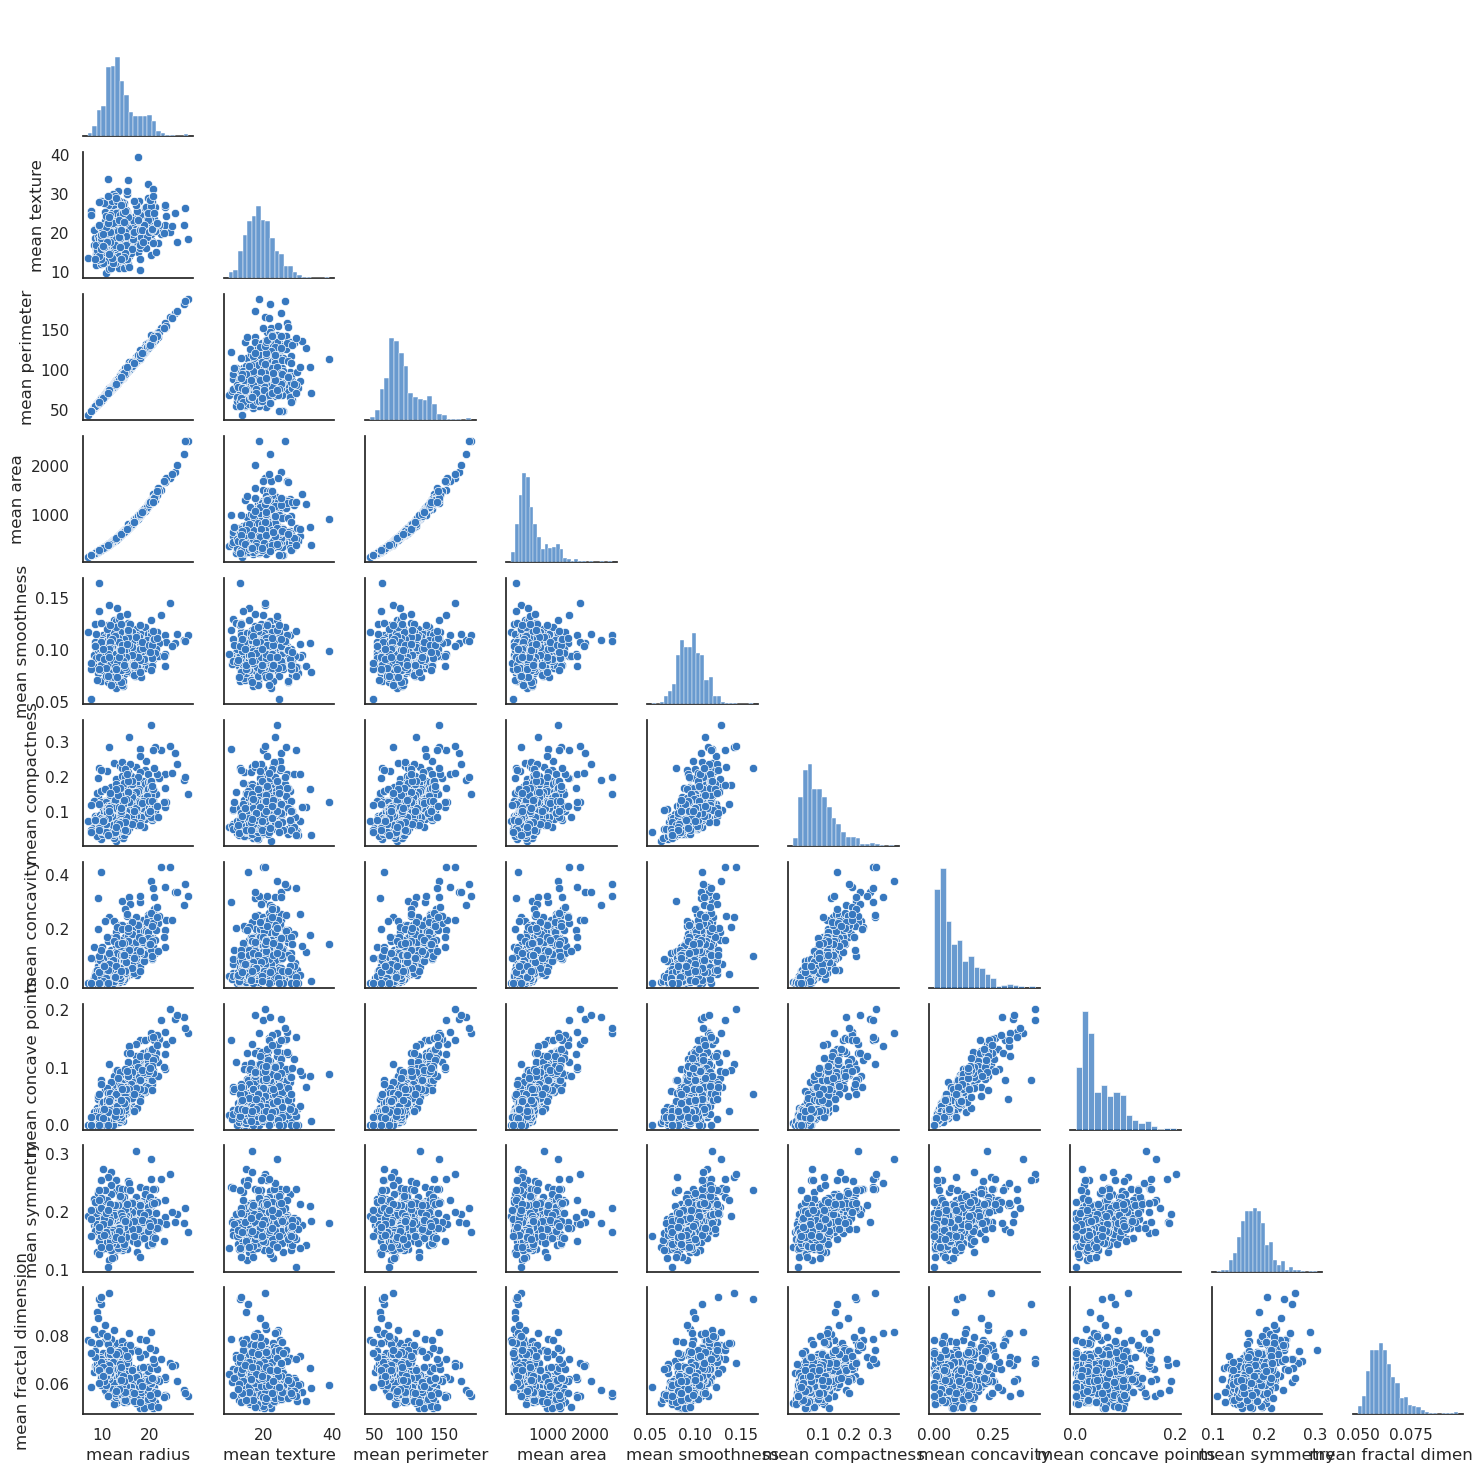

In [ ]:
data = load_breast_cancer()
# print(data['DESCR'])
# data
# type(data)
num_features = 10
df = pd.DataFrame(data["data"][:,:num_features], columns=data["feature_names"][:num_features])

df.shape
df.head()

#Definimos resultados, que en este caso son binarios
dfy = data["target"]
dfy.shape, dfy[:100]

# Visualización de los datos
_ = sns.pairplot(df, height=1.5, corner = True)

El perímetro y el área están altamente correlacionadas con el radio, los sacamos de nuestras variables de estudio causal.

In [ ]:
fea_cols = df.columns[[(not df.columns[i].endswith("perimeter")) \
                     and (not df.columns[i].endswith("area")) \
                     for i in range(df.shape[1])]]

dfX = pd.DataFrame(df[fea_cols])

print(dfX.shape, dfy.shape)

# Estandarización de las variables
X = np.array((dfX - dfX.mean())/dfX.std())

(569, 8) (569,)


## Chequeo predictivo
### Enmascaramiento de datos

Vamos a ocultar, al azar, valores de la matriz de variables/intervenciones. Para eso tomamos su tamaño para generan los índices a ocultar, según la fracción deseda.

In [ ]:
num_datapoints, data_dim = X.shape

holdout_portion = 0.2 #20% aproximado de datos ocultos
n_holdout = int(holdout_portion * num_datapoints * data_dim)
print('n_holdout', n_holdout)

# Genero los vectores de coordenadas al samplear "n_holdout" de cada uno
holdout_row = np.random.randint(num_datapoints, size=n_holdout)
holdout_col = np.random.randint(data_dim, size=n_holdout)

# Generamos la matriz a partir de las coordenadas previas
holdout_mask = (sparse.coo_matrix((np.ones(n_holdout),(holdout_row, holdout_col)),
                                  shape = X.shape)).toarray()

holdout_mask = np.minimum(1, holdout_mask) #los repetidos se suman, limpiamos las valores > 1

holdout_subjects = np.unique(holdout_row) #tomo las filas (sujetos/muestras observadas) que tienen datos ocultos

print('holdout_mask shape', holdout_mask.shape)
print('holdout_mask =')
print(holdout_mask[:3,:])

n_holdout 910
holdout_mask shape (569, 8)
holdout_mask =
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0.]]


Oculto los datos de la matriz multiplicándola por 1-H (vemos los que NO retuvimos).

Nota: es distinto que sets train-test usuales ya que no ocultamos, necesariamente, toda una muestra y nada de otras, son fracciones aleatorias de cada fila para que, en total, haya a lo sumo "holdout_portion" oculto.

In [ ]:
x_train = np.multiply(1-holdout_mask, X)
x_vad = np.multiply(holdout_mask, X)

## Modelado

Importamos las librerías de inferencia. Abajo les dejo el código para instalar numpyro que no viene por default en colab.

In [ ]:
import pymc as pm
import pymc.sampling_jax
import arviz as az

In [ ]:
# !pip install numpyro


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.1/348.1 kB 9.5 MB/s eta 0:00:00


## Chequeo predictivo


### Modelos de factores
Definición de los modelos de factores para el chequeo predictivo y los argumentos de muestreo para la inferencia.
Son los modelos que vimos en la charla, y usamos el lenguaje PyMC que mencioné brevemente, pero que dió en profundidad Tomás Capretto.

Para el caso del modelo de factores a aplicar en el chequeo predictivo, pasamos a la función también la máscara, de manera de ocultar los mismos valores dentro de la media de la verosimilitud (y son de la misma estructura que los que vamos a darles como observados!).

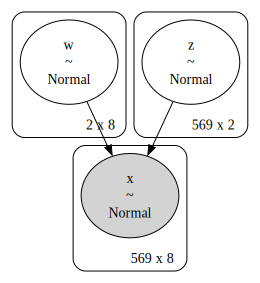

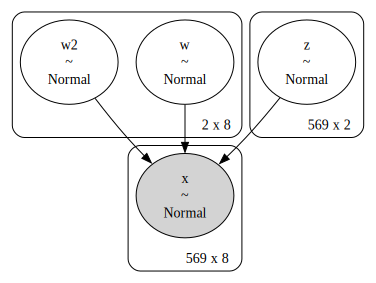

In [ ]:
# Damos la opción de modelado lineal y cuadrático
# Lineal: x_n con media z_n * W
# Cuadrático: x_n con media b + z_n * W + (z_n**2) * W_2

def factor_model_mask(data, data_dim, latent_dim, num_datapoints, stddv_datapoints, mask,
                    sigma_prior = 1, form = 'linear', mu_w = 0):
    with pm.Model() as model:
        w = pm.Normal('w', mu = mu_w,
                      sigma = sigma_prior,
                      shape = (latent_dim, data_dim))

        z = pm.Normal('z', mu = 0,
                      sigma = sigma_prior,
                      shape = (num_datapoints, latent_dim))

        if form == 'linear':
            x = pm.Normal('x', mu = (pm.math.dot(z,w))*mask, #acá multiplicamos
                         sigma = stddv_datapoints,
                         shape = (num_datapoints, data_dim),
                         observed = data)


        elif form == 'quadratic':
            w2 = pm.Normal('w2', mu = mu_w,
                          sigma = 1,
                          shape = (latent_dim, data_dim))
            x = pm.Normal('x', mu = (pm.math.dot(z,w) + pm.math.dot(np.square(z),w2))*mask,
                         sigma = stddv_datapoints,
                         shape = (num_datapoints, data_dim),
                         observed = data)
        return model
# Determinación del número de variables confundidoras latentes y de la desviación estándar de los datos.
latent_dim = 2
stddv_datapoints = 0.1

###Recordatorio: x_train = np.multiply(1-holdout_mask, X)

# Instanciamos y graficamos los modelos
model = factor_model_mask(data = x_train,
                        data_dim=data_dim,
                        latent_dim=latent_dim,
                        num_datapoints=num_datapoints,
                        stddv_datapoints=stddv_datapoints,
                        mask=1-holdout_mask)

model_quad = factor_model_mask(data = x_train,
                        data_dim=data_dim,
                        latent_dim=latent_dim,
                        num_datapoints=num_datapoints,
                        stddv_datapoints=stddv_datapoints,
                        mask=1-holdout_mask,
                        form = 'quadratic')
pm.model_to_graphviz(model)
pm.model_to_graphviz(model_quad)

In [ ]:
# Definición de los argumentos de muestreo

draws = 4000 #número de muestras a tomar por cada cadena
tune = 2000 # número de muestras a realizar en el espacio de "calentamiento" de las cadenas, antes de los draws (se descartan)
chains = 3 # número de cadenas
target = 0.9

# Función de muestreo. Toma el modelo, los argumentos y muestrea con jax (por eso numpyro)

# Por una cuestión computacional, vamos a eliminar el paso de cálculo de log_likelihood de las muestras (tiempo y memoria) con kwargs
def run_model_no_log(model, draws = draws, tune = tune, chains = chains,
                     kwargs = {'log_likelihood': False}, target = target, random_seed = None):
    with model:
        idata = pm.sampling_jax.sample_numpyro_nuts(draws = draws, tune = tune,
                                                    chains = chains, idata_kwargs=kwargs,
                                                    target_accept = target, random_seed = random_seed)
        gc.collect()
    return idata

In [ ]:
%%time
# Corremos la inferencia del chequeo predictivo sobre el modelo lineal
idata = run_model_no_log(model, target = target, draws = draws, tune = tune, chains = chains, random_seed = 123)

Compiling...


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compilation time =  0:00:00.470078
Sampling...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Sampling time =  0:00:25.791893
Transforming variables...
Transformation time =  0:00:00.003247
CPU times: user 1min 1s, sys: 1.11 s, total: 1min 2s
Wall time: 26.4 s


In [ ]:
%%time
# Lo mismo para el cuadrático
idata_quad = run_model_no_log(model_quad, target = target, draws = draws, tune = tune, chains = chains, random_seed = 123)

Compiling...
Compilation time =  0:00:00.520507
Sampling...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Sampling time =  0:05:00.910943
Transforming variables...
Transformation time =  0:00:00.003688
CPU times: user 8min 32s, sys: 1.44 s, total: 8min 33s
Wall time: 5min 1s


Si quisieran guardar y abrir estas trazas, pueden hacerlo con la librería arviz (que maneja Xarrays los objetos que son estos idata's).

In [1]:
# path = "su_ruta_de_guardado"
# Guardado
# idata.to_netcdf(path + "idata", compress = True)
# idata_quad.to_netcdf(path + "idata_quad", compress = True)

# Lectura
# idata = az.from_netcdf(path + "idata")
# idata_quad = az.from_netcdf(path + "idata_quad")

### Predictive score
Generamos las réplicas de los datos que estaban ocultos, $X_{held}^{rep}$ a partir de las muestras posteriores, usando la posterior predictiva (sample_posterior_predictive).
Hay un paso de selección con "slicing" para tomar muestsa no correlacionadas, según el valor the thineo (raleo).

In [ ]:
%%time
def posterior_sampling_thinned(pymc_model, data, thinned_by, return_data = False, variables = ["x"]):
    with pymc_model:
        posterior = pm.sample_posterior_predictive(data.sel(draw=slice(None, None, thinned_by)), return_inferencedata = return_data, var_names = variables)
    return posterior

holdout_subjects = np.unique(holdout_row)
p = 50
full_p_values = np.zeros((p,2))

for p in range(p):
    #1 de cada cuantas muestras de las cadenas de idata nos quedamos
    thinned_by = 10
    # sampleos de las variables listadas en cada caso
    idata_posterior = posterior_sampling_thinned(model, idata, thinned_by, return_data = True, variables = ["x", "w", "z"])
    idata_posterior_quad = posterior_sampling_thinned(model_quad, idata_quad, thinned_by, return_data = True, variables = ["x", "w", "z", "w2"])

    # Por comodida de cálculo, juntamos todas las cadenas y muestras en una tira
    idata_posterior = idata_posterior.stack(sample=["chain", "draw"])
    idata_posterior_quad = idata_posterior_quad.stack(sample=["chain", "draw"])

    # generamos aleatoriedad de posiciones de las cadenas
    rng = np.random.RandomState(123)
    lista = list(range(0,250))
    rng.shuffle(lista)
    n_rep, n_eval = 100,100
    # Variables replicadas del modelo lineal
    x_generated = idata_posterior.posterior_predictive['x'].values[:,:,lista[:n_rep]]
    w_sample = idata_posterior.posterior_predictive["w"].values[:,:,lista[:n_rep]]
    z_sample = idata_posterior.posterior_predictive["z"].values[:,:,lista[:n_rep]]

    # Variables replicadas del modelo lineal
    x_generated_quad = idata_posterior_quad.posterior_predictive['x'].values[:,:,lista[:n_rep]]
    w_sample_quad = idata_posterior_quad.posterior_predictive['w'].values[:,:,lista[:n_rep]]
    z_sample_quad = idata_posterior_quad.posterior_predictive['z'].values[:,:,lista[:n_rep]]
    w2_sample_quad = idata_posterior_quad.posterior_predictive['w2'].values[:,:,lista[:n_rep]]

    # Instanciamos matrices de ceros donde rellenar con los valores de datos generados
    holdout_gen = np.zeros_like(x_generated)
    holdout_gen_quad = np.zeros_like(x_generated_quad)

    for i in range(n_rep):
        holdout_gen[:,:,i] = np.multiply(x_generated[:,:,i],holdout_mask)
        holdout_gen_quad[:,:,i] = np.multiply(x_generated_quad[:,:,i],holdout_mask)

    # Test de la logp esperada - caso lineal
    obs_ll = []
    rep_ll = []
    for j in range(n_eval): #corre n_eval = 100 veces
            holdoutmean_sample = np.multiply(z_sample[:,:,j].dot(w_sample[:,:,j]), holdout_mask)
            obs_ll.append(np.mean(stats.norm(holdoutmean_sample, \
                            stddv_datapoints).logpdf(x_vad), axis=1))

            rep_ll.append(np.mean(stats.norm(holdoutmean_sample, \
                            stddv_datapoints).logpdf(holdout_gen[:,:,j]),axis=1))

    obs_ll_per_zi, rep_ll_per_zi = np.mean(np.array(obs_ll), axis=0), np.mean(np.array(rep_ll), axis=0)


    # Test de la logp esperada - caso cuadrático
    obs_ll_quad = []
    rep_ll_quad = []
    for j in range(n_eval):
            holdoutmean_sample = np.multiply(np.dot(z_sample_quad[:,:,j],w_sample_quad[:,:,j]) + np.dot(np.square(z_sample_quad[:,:,j]),w_sample_quad[:,:,j]), holdout_mask)
            obs_ll_quad.append(np.mean(stats.norm(holdoutmean_sample, \
                            stddv_datapoints).logpdf(x_vad), axis=1))

            rep_ll_quad.append(np.mean(stats.norm(holdoutmean_sample, \
                            stddv_datapoints).logpdf(holdout_gen[:,:,j]),axis=1))

    obs_ll_per_zi_quad, rep_ll_per_zi_quad = np.mean(np.array(obs_ll_quad), axis=0), np.mean(np.array(rep_ll_quad), axis=0)

## Puntajes predictivos
    # Caso lineal
    pred_scores = np.array([np.mean(rep_ll_per_zi[i] < obs_ll_per_zi[i]) for i in range(num_datapoints)])
    holdout_subjects = np.unique(holdout_row)
    overall_pval = np.mean(pred_scores[holdout_subjects])
    # Caso cuadrático
    pred_scores_quad = np.array([np.mean(rep_ll_per_zi_quad[i] < obs_ll_per_zi_quad[i]) for i in range(num_datapoints)])
    holdout_subjects = np.unique(holdout_row)
    overall_pval_quad = np.mean(pred_scores_quad[holdout_subjects])
    # Los juntamos
    full_pred_scores[p,0] = np.mean(pred_scores[holdout_subjects])
    full_pred_scores[p,1] = np.mean(pred_scores_quad[holdout_subjects])

    gc.collect() #limpiamos memoria

Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


Sampling: [w, x, z]


Sampling: [w, w2, x, z]


CPU times: user 35.9 s, sys: 2.27 s, total: 38.1 s
Wall time: 38 s


mean values [0.06511013 0.1239207 ]
std values [0.00941907 0.01944229]


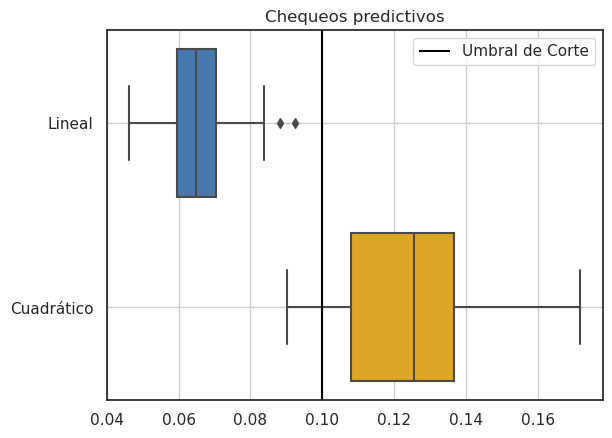

In [ ]:
# Visualización de resultados en diagrama de cajas
print('mean values', np.mean(full_p_values, axis = 0))
print('std values', np.std(full_p_values, axis = 0))

ax = sns.boxplot(full_pred_scores, orient = "h")
_ = ax.set_title("Chequeos predictivos")
_ = ax.get_ylim()
_ = ax.vlines(0.1, ymin=-0.5, ymax=1.5, label= "Umbral de Corte", colors = "k")

_ = ax.legend()
_ = ax.grid(True)
_ = ax.set_yticklabels(["Lineal", "Cuadrático"])
plt.show()

## Modelo de Factores completo
Una vez resuelto qué modelo supera el chequeo predictivo, se aplica el modelo de factores para conseguir las variables confundidoras sustitutas.
En este caso usamos el modelo cuadrático, ya que
$pred\_score_{quad} > 0.1$, mientras que
$pred\_score_{lin} < 0.1$.

Estas estructuras de modelos son las mismas que las del modelo de factores, ahora SIN enmascararar. Vemos todos los datos

Modelo de factores sin enmascarar


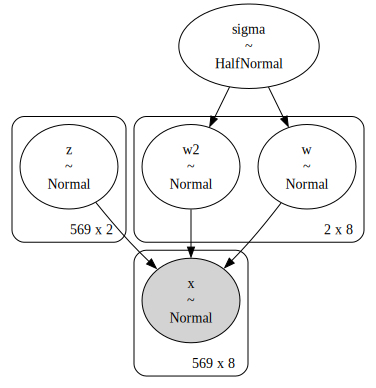

In [ ]:
def factor_model(data, data_dim, latent_dim, num_datapoints, stddv_datapoints,
                    sigma_prior = 1, form = 'linear', mu_w = 0):
    with pm.Model() as model:

        z = pm.Normal('z', mu = 0,
                      sigma = sigma_prior,
                      shape = (num_datapoints, latent_dim))

        sigma_w = pm.HalfNormal("sigma", sigma=1)
        #sw = pm.Normal('sw', mu = sigma_w, sigma = sigma_w_sd)

        w = pm.Normal('w', mu = mu_w,
                      sigma = sigma_w,
                      shape = (latent_dim, data_dim))

        if form == 'linear':
            mu_likelihood = pm.math.dot(z,w)


        elif form == 'quadratic':
            w2 = pm.Normal('w2', mu = mu_w,
                          sigma = sigma_w,
                          shape = (latent_dim, data_dim))

            mu_likelihood = pm.math.dot(z,w) + pm.math.dot(np.square(z),w2)

        x = pm.Normal('x', mu = mu_likelihood,
                         sigma = stddv_datapoints,
                         shape = (num_datapoints, data_dim),
                         observed = data)
        return model


full_model_quad = factor_model(data = X,
                             data_dim = data_dim,
                             latent_dim = latent_dim,
                             num_datapoints=num_datapoints,
                             stddv_datapoints=stddv_datapoints,
                             form = 'quadratic')
print("Modelo de factores sin enmascarar")
pm.model_to_graphviz(full_model_quad)

In [ ]:
%%time
full_idata_quad = run_model_no_log(full_model_quad, random_seed = 123)

Compiling...
Compilation time =  0:00:00.691919
Sampling...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Sampling time =  0:05:02.878261
Transforming variables...
Transformation time =  0:00:00.017512
CPU times: user 8min 48s, sys: 1.45 s, total: 8min 49s
Wall time: 5min 3s


Utilizamos valores de inferencia para reemplazar las variables confundidoras en el modelo de resultados

In [ ]:
# Definimos media y modo y listamos las métricas de resumen de nuestro interés
def median_sd(x):
    median = np.percentile(x, 50)
    sd = np.sqrt(np.mean((x-median)**2))
    return sd

def mode(x):
    binned = int(np.sqrt(len(x))/2)
    counts,bins = np.histogram(x, bins = binned)
    peak = np.argmax(counts)
    mode = np.mean((bins[peak], bins[peak+1]))
    return mode

func_dict = {
    'mean': np.mean,
    "std": np.std,
    'mode':mode,
    "5%": lambda x: np.percentile(x, 5),
    "median": lambda x: np.percentile(x, 50),
    "95%": lambda x: np.percentile(x, 95),
    "median_std": median_sd}

### Muestreo para generar variables confundidoras sustitutas

Tomamos los valores medios de la posterior de "z" para usar como valor sustituto de las variables confundidoras.

In [ ]:
full_summary_z = az.summary(full_idata_quad.posterior, stat_funcs = func_dict, extend = False, var_names = ['z'])

z_mean_vals = full_summary_z['mean'].values.reshape((-1,latent_dim))
np.shape(z_mean_vals)

## Modelo de resultados (Outcome model)

Planteamos el modelo de resultados presentado en la charla, ver cómo ahora tenemos el score dentro de la

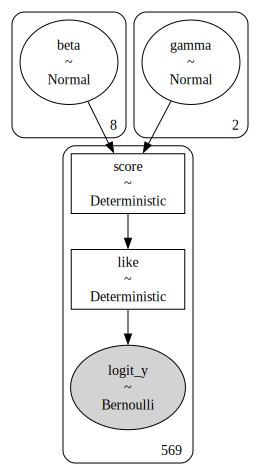

In [ ]:
target_dim = 1 #(y es 0,1 dejó o no)
mu_prior = 0
sigma_prior = 1
with pm.Model() as outcome_model:
  beta = pm.Normal('beta', mu =  mu_prior,
                sigma = sigma_prior,
                shape = data_dim)

  gamma = pm.Normal('gamma', mu =  mu_prior,
                sigma = sigma_prior,
                shape = latent_dim)
  score = pm.Deterministic('score', pm.math.dot(X,beta) + pm.math.dot(z_mean_vals,gamma))
  #acá están entrando las variables observadas y confundidoras sustitutas

  likelihood = pm.Deterministic('like', pm.invlogit(score))

  y = pm.Bernoulli('logit_y', p = likelihood, observed = dfy)

pm.model_to_graphviz(outcome_model)

In [ ]:
%%time
outcome_data = run_model_no_log(outcome_model, random_seed = 123)

Compiling...
Compilation time =  0:00:00.714935
Sampling...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Sampling time =  0:00:03.614372
Transforming variables...
Transformation time =  0:00:00.201551
CPU times: user 7.13 s, sys: 168 ms, total: 7.3 s
Wall time: 4.67 s


 Si quisiéramos ver más estadística de los valores reportados se puede jugar con el resumen y tratar las trazas.

In [ ]:

outcome_summary = get_summary(outcome_data, var_name = ["beta", "gamma"])
my_causes_mean = outcome_summary["mean"].values
my_causes_sd = outcome_summary["std"].values

Tomamos los valores y desviaciones reportadas por los autores del paper de presentación del deconfounder. Acá no generamos datos sintéticos como en la parte 1, por lo que contrastamos con respuestas previas.

El gráfico muestra las trazas posteriores para cada coeficiente, con el valor estimado y la región sombreada marcada a partir de los valores reportados en el paper [Wang & Blei (2019)](https://arxiv.org/pdf/1805.06826).

Para el estimador de radio medio, en este caso, el valor reportado en el artículo no supera tests estadísticos de manera que sea factible que provenga de nuestra distribución. (no lo mostramos en este notebook).

           mean    std   mode     5%  median    95%  median_std
beta[0]  -2.829  0.536 -2.868 -3.728  -2.825 -1.952       0.536
beta[1]  -1.701  0.256 -1.733 -2.138  -1.696 -1.291       0.256
beta[2]  -0.791  0.318 -0.727 -1.320  -0.785 -0.274       0.318
beta[3]   0.392  0.507  0.345 -0.449   0.394  1.224       0.507
beta[4]  -1.318  0.468 -1.331 -2.085  -1.316 -0.548       0.468
beta[5]  -2.338  0.639 -2.425 -3.402  -2.340 -1.286       0.639
beta[6]  -0.351  0.253 -0.348 -0.759  -0.350  0.062       0.253
beta[7]   0.629  0.424  0.481 -0.065   0.627  1.325       0.424
gamma[0] -0.094  0.362 -0.122 -0.694  -0.094  0.505       0.362
gamma[1]  1.433  0.406  1.339  0.770   1.429  2.104       0.406


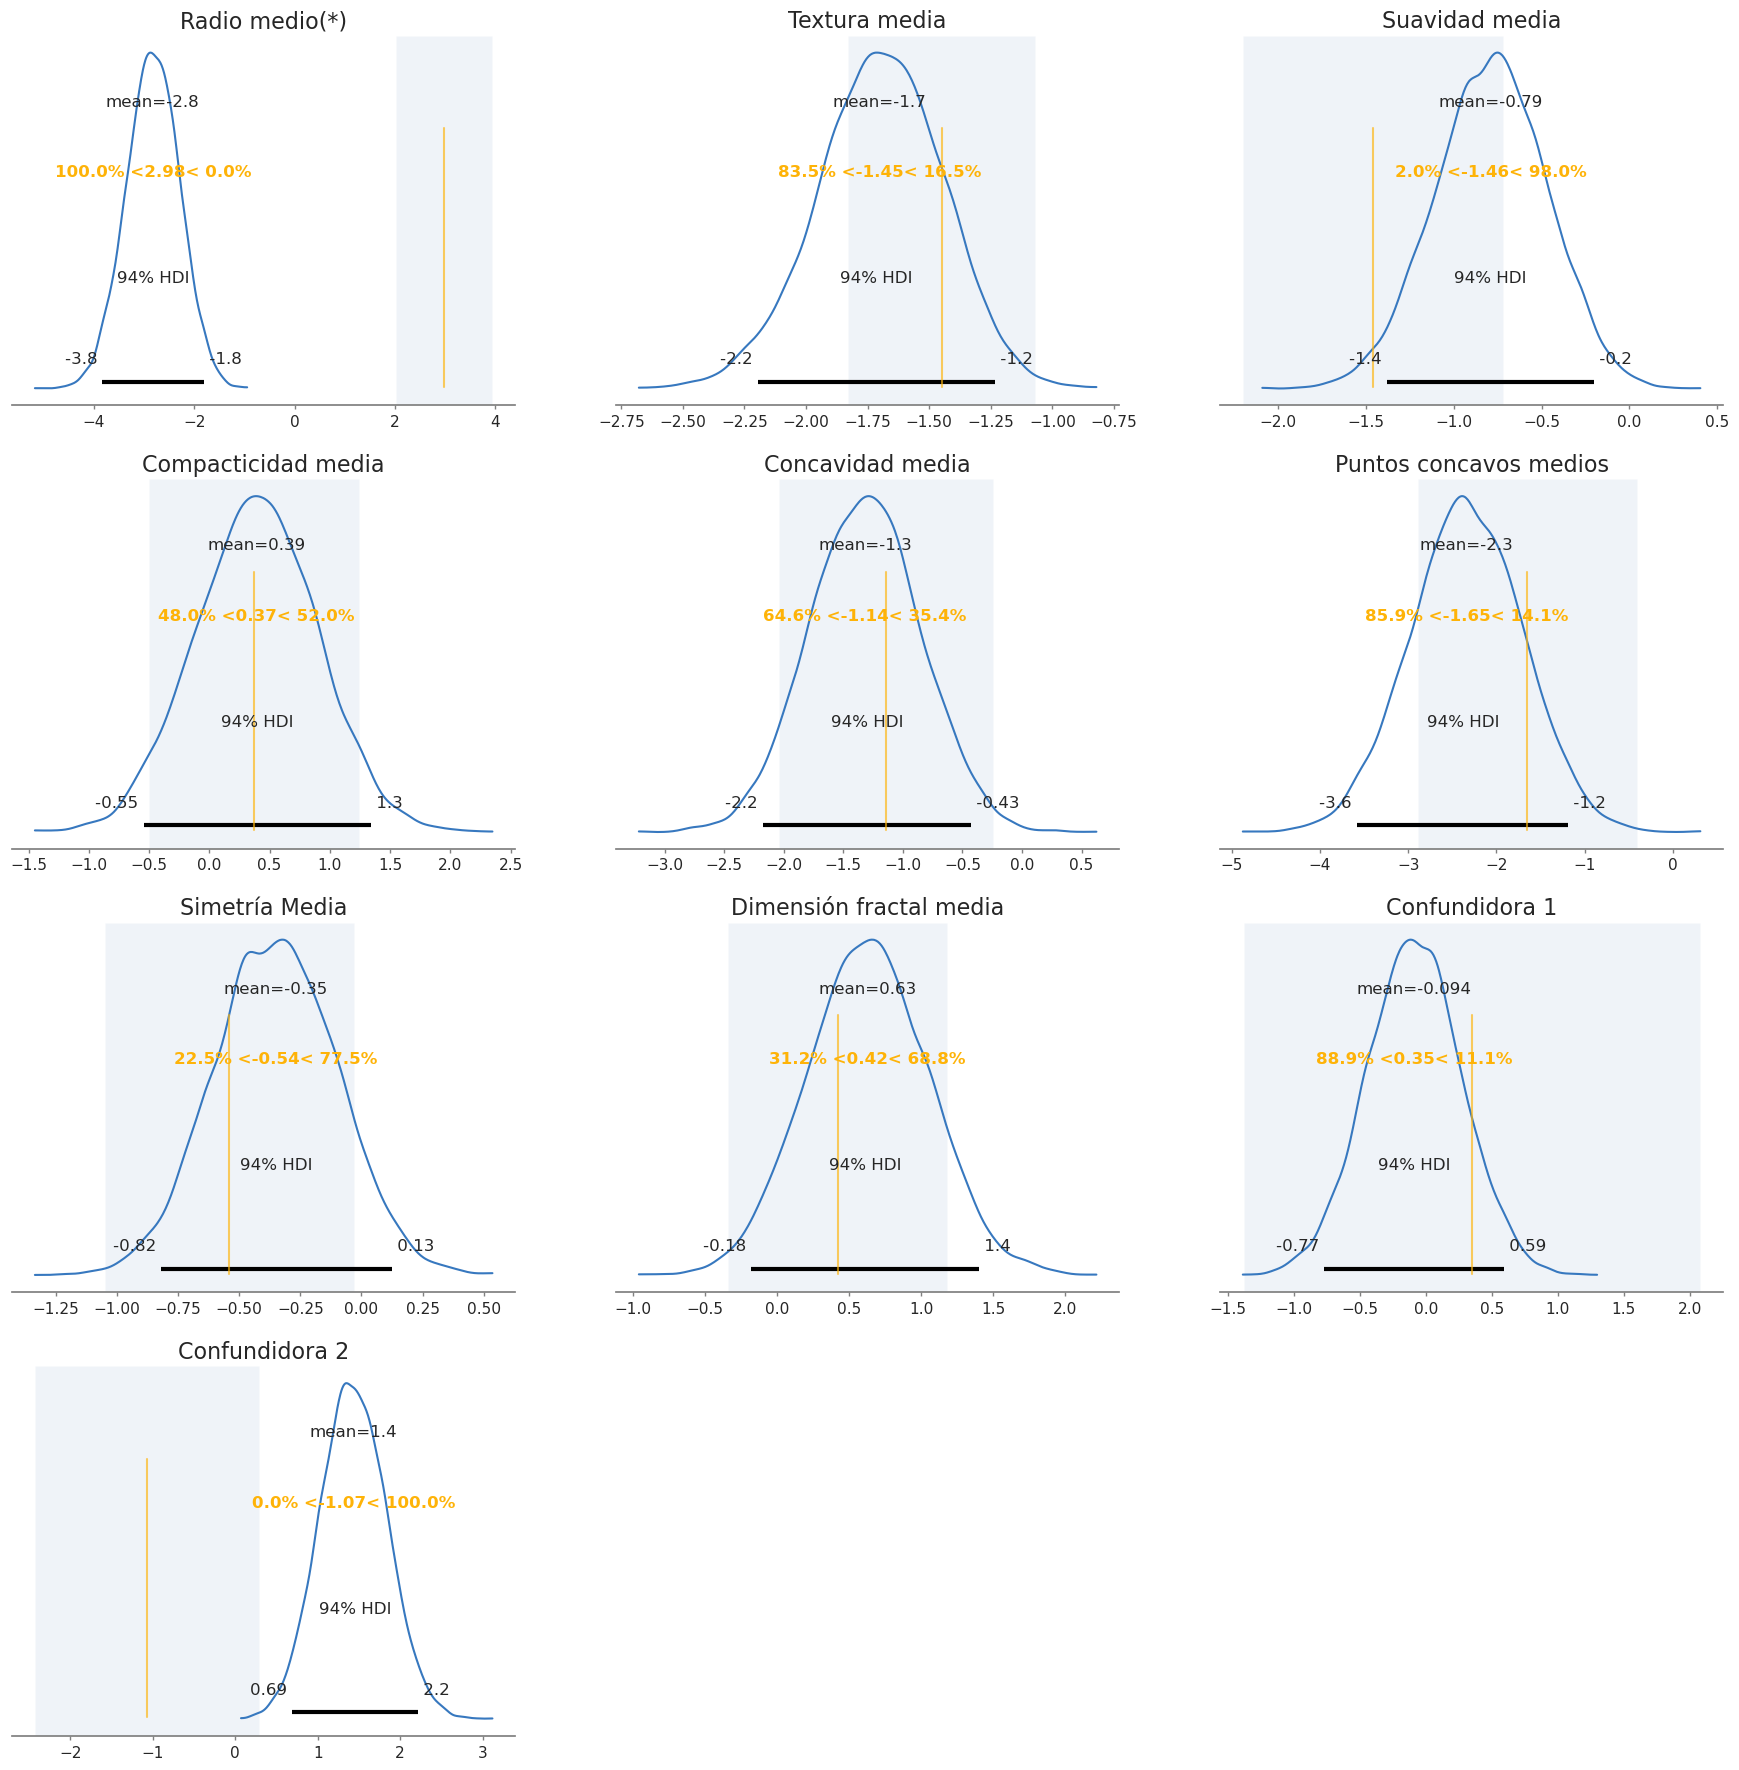

In [ ]:
blei_causes_mean = np.array((2.97783,-1.44867, -1.46326,0.368069,-1.13524, -1.65108, -0.536826,0.416358, 0.3544, -1.0729)).round(2)
blei_causes_std = np.array((0.964373,0.380799, 0.743651, 0.87232, 0.90044, 1.23964, 0.506479, 0.765082, 1.734, 1.360)).round(3)
blei_causes_min = (blei_causes_mean-blei_causes_std).round(2)
blei_causes_max = (blei_causes_mean+blei_causes_std).round(2)
nombres = ["Radio medio(*)", "Textura media", "Suavidad media", "Compacticidad media", "Concavidad media", "Puntos concavos medios", "Simetría Media", "Dimensión fractal media", "Confundidora 1", "Confundidora 2"]
axs = az.plot_posterior(outcome_data, var_names = ["beta", "gamma"], ref_val = list(blei_causes_mean), grid = (4,3))
index = 0los valores

for i in range(4):
    for j in range(3):
        if index < len(nombres):
            _ = axs[i, j].set_title(nombres[index], size=16)
            _ = axs[i, j].axvspan(xmin=blei_causes_min[index], xmax=blei_causes_max[index], facecolor="#B0C4DE", alpha=0.2)
        index += 1
plt.show()

Disclaimer: hay varios chequeos intermedios de inferencia generales que no estamos realizando.

# Otros materiales/bibliografía de interés

* [Repositorio de algoritmos causales](https://github.com/rguo12/awesome-causality-algorithms)
Uno de los artículos en respuesta al deconfounder, que muestra algunas de sus limitaciones.
* [Naive regression requires weaker assumptions than factor
models to adjust for multiple cause confounding - 2023](https://dcknox.github.io/files/GrimmerKnoxStewart_NaiveRegressionDeconfounder.pdf)